In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as M
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset

from sklearn.utils import shuffle

import numpy as np

from PIL import Image
import IPython.display as ipd

In [2]:
CUDA_VISIBLE_DEVICES = 5
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img + 1, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            #nn.Sigmoid(),
        )
        
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x, img):
        #embedding = self.embed(labels).view(labels.shape[0], CH, self.img_size, self.img_size)
        x = torch.cat([x, img], dim=1) # N x C x size x size
        return self.disc(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.gen = nn.Sequential(
            self._block(z_dim+embed_size, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)
        
        self.project = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=0),
            nn.InstanceNorm2d(32, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=4, padding=0),
            nn.InstanceNorm2d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 100, kernel_size=4, stride=4, padding=0),
            #nn.InstanceNorm2d(100, affine=True),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(0.2)
        )
    
    
    def forward(self, x, img):
        embedding = self.project(img)
        x = torch.cat([x, embedding], dim=1)
        return self.gen(x)

In [5]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, balanced_data_fmnist, balanced_data_mnist, balanced_targets, transform_mnist=None):
        
        self.balanced_data_fmnist = balanced_data_fmnist
        self.balanced_data_mnist = balanced_data_mnist
        self.balanced_targets = balanced_targets
        self.transform_mnist = transform_mnist

    def __len__(self):
        return len(self.balanced_targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {'mnist': self.balanced_data_mnist[idx],
                  'fmnist': self.balanced_data_fmnist[idx],
                  'targets': self.balanced_targets[idx]}

        if self.transform_mnist:
            sample['mnist'] = self.transform_mnist(Image.fromarray(sample['mnist']))
            sample['fmnist'] = self.transform_mnist(Image.fromarray(sample['fmnist']))

        return sample

In [6]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
def gradient_penalty(critic, labels, real, fake, device='cpu'):
    bs, c, h, w = real.shape
    epsilon = torch.rand((bs, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    
    mixed_scores = critic(interpolated_images, labels)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1)**2)
    
    return gradient_penalty

In [8]:
def sort_and_balance_data(dataset_fmnist, dataset_mnist):
    balanced_targets = []
    balanced_dataset_fmnist = torch.zeros((50000, 28, 28), dtype=torch.uint8)
    balanced_data_mnist = torch.zeros((50000, 28, 28), dtype=torch.uint8)
    for i in range(0, 10):
        balanced_dataset_fmnist[i*5000:5000*(i+1)] = dataset_fmnist.data[dataset_fmnist.targets==i][0:5000]
        balanced_data_mnist[i*5000:5000*(i+1)] = dataset_mnist.data[dataset_mnist.targets==i][0:5000]
        balanced_targets += [i] * 5000

    balanced_targets = torch.LongTensor(balanced_targets)
    
    return balanced_dataset_fmnist.numpy(), balanced_data_mnist.numpy(), balanced_targets

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LR = 1e-4
BS = 128
IMG_SIZE = 64
CH = 1

Z_DIM = 100

EPOCHS = 10

N_CRIT = 5
#CLIP = 0.01

LAMBDA = 10
B1 = 0.0
B2 = 0.9

CLASSES = 10
GEN_EMB = 100

FEATURES_DISC, FEATURES_GEN = 64, 64

In [10]:
transform_mnist = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CH)], [0.5 for _ in range(CH)]
        )
    ]
)

dataset_mnist = datasets.MNIST(root='./data', train=True, download=False)
dataset_fmnist = datasets.FashionMNIST(root='./data', train=True, download=False)

balanced_data_fmnist, balanced_data_mnist, balanced_targets = sort_and_balance_data(dataset_fmnist, dataset_mnist)
balanced_data_fmnist, balanced_data_mnist, balanced_targets = shuffle(balanced_data_fmnist, balanced_data_mnist, balanced_targets,
                                                                     random_state=42)
dataset = FaceLandmarksDataset(balanced_data_fmnist, balanced_data_mnist, balanced_targets,
                               transform_mnist=transform_mnist)

loader = DataLoader(dataset, batch_size=BS, shuffle=True)

gen = Generator(Z_DIM, CH, FEATURES_GEN, CLASSES, IMG_SIZE, GEN_EMB).to(device)
critic = Discriminator(CH, FEATURES_DISC, CLASSES, IMG_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(B1, B2))
opt_critic = optim.Adam(critic.parameters(), lr=LR, betas=(B1, B2))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

gen.train()
critic.train()
print()

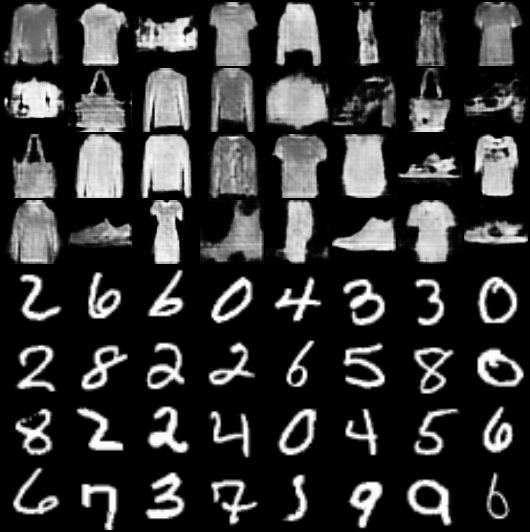

In [11]:
fixed_noise = torch.randn((BS, Z_DIM, 1, 1)).to(device)
fixed_mnist = iter(loader).next()['mnist'].to(device)
for epoch in range(EPOCHS):
    loader = DataLoader(dataset, batch_size=BS, shuffle=True)
    for batch_idx, data_dict in enumerate(loader):
        mnist_imgs = data_dict['mnist'].to(device)
        fmnist_imgs = data_dict['fmnist'].to(device)
        if mnist_imgs.shape[0] == BS:
            for _ in range(N_CRIT):
                noise = torch.randn((BS, Z_DIM, 1, 1)).to(device)
                fake = gen(noise, mnist_imgs)

                critic_real = critic(fmnist_imgs, mnist_imgs).reshape(-1) #N
                critic_fake = critic(fake, mnist_imgs).reshape(-1)
                #RMSprop minimizes the loss so to maximize it we add a minus
                gp = gradient_penalty(critic, mnist_imgs, fmnist_imgs, fake, device=device)
                loss_critic = - (torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA * gp
                critic.zero_grad()
                loss_critic.backward(retain_graph=True)
                opt_critic.step()

            output = critic(fake, mnist_imgs).reshape(-1)
            loss_gen = -torch.mean(output)
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

            with torch.no_grad():
                fake = gen(fixed_noise, fixed_mnist)

                img_grid_fake = torchvision.utils.make_grid(fake[:BS//4], normalize=True)
                img_grid_fake *= 255
                img_grid_mnist = torchvision.utils.make_grid(fixed_mnist[:BS//4], normalize=True)
                img_grid_mnist *= 255
                out_img = torch.cat([img_grid_fake, img_grid_mnist], 1)
                ipd.display(Image.fromarray(np.einsum('ijk->jki', out_img.cpu().numpy().astype(np.uint8))))
                ipd.clear_output(wait=True)

In [12]:
num = 0
noise = torch.randn((BS, Z_DIM, 1, 1)).to(device)
labels = torch.Tensor([num]*BS).type(torch.LongTensor).to(device)
with torch.no_grad():
    fake = gen(noise, labels)
    print(labels)
    img_grid_fake = torchvision.utils.make_grid(fake[:BS], normalize=True)
    img_grid_fake *= 255
    ipd.display(Image.fromarray(np.einsum('ijk->jki', img_grid_fake.cpu().numpy().astype(np.uint8))))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 1, 4, 4], but got 1-dimensional input of size [128] instead